# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

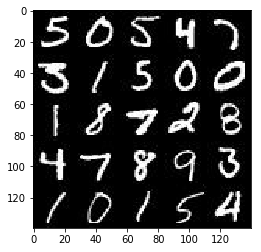

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

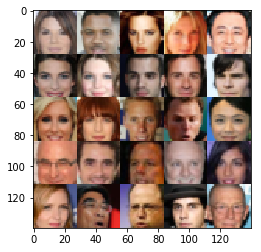

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None)
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# Define leaky relu
lrelu = lambda x: tf.maximum(0.1*x, x)


def conv(inputs, filters, ksize=5, strides=2, padding='same', batch_norm=True):
    """convenience function for creating convolutional layers - sets default values for 
    ksize, strides, padding and will do batch normalization when necessary"""
    x = tf.layers.conv2d(inputs, filters, ksize, strides, padding)
    return lrelu(x) if not batch_norm else lrelu(tf.layers.batch_normalization(x, training=True))


def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = conv(images, 64, batch_norm=False)  # 28x28x3 -> 14x14x64, no batch_norm on first layer
        h2 = conv(h1, 128)  # 14x14x64 -> 7x7x128
        h3 = conv(h2, 256)  # 7x7x128 -> 4x4x256
        
        flattened = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flattened, 1)
        out = tf.sigmoid(logits)
    
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        h1 = tf.layers.dense(z, 7*7*256)
        h1 = tf.reshape(h1, (-1, 7, 7, 256))
        h1 = lrelu(tf.layers.batch_normalization(h1, training=is_train))
        
        h2 = tf.layers.conv2d_transpose(h1, 128, 5, 2, padding='same')
        h2 = lrelu(tf.layers.batch_normalization(h2, training=is_train))
        
        h3 = tf.layers.conv2d_transpose(h2, 64, 5, 2, padding='same')
        h3 = lrelu(tf.layers.batch_normalization(h3, training=is_train))
        
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 1, padding='same')
        out = tf.tanh(logits)
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_logits_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    g_vars = [v for v in t_vars if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z,
                                                    lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z,
                                                    lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z,
                                                    lr: learning_rate})
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 8.3037... Generator Loss: 0.0007
Epoch 1/2... Batch 20... Discriminator Loss: 1.7888... Generator Loss: 0.8759
Epoch 1/2... Batch 30... Discriminator Loss: 1.7308... Generator Loss: 0.8772
Epoch 1/2... Batch 40... Discriminator Loss: 1.8416... Generator Loss: 1.3467
Epoch 1/2... Batch 50... Discriminator Loss: 1.6847... Generator Loss: 0.8959
Epoch 1/2... Batch 60... Discriminator Loss: 1.6538... Generator Loss: 1.0421
Epoch 1/2... Batch 70... Discriminator Loss: 1.4880... Generator Loss: 0.6612
Epoch 1/2... Batch 80... Discriminator Loss: 1.6556... Generator Loss: 1.3294
Epoch 1/2... Batch 90... Discriminator Loss: 1.4701... Generator Loss: 0.8625
Epoch 1/2... Batch 100... Discriminator Loss: 1.4986... Generator Loss: 1.1792


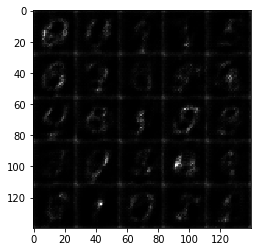

Epoch 1/2... Batch 110... Discriminator Loss: 1.5855... Generator Loss: 1.1404
Epoch 1/2... Batch 120... Discriminator Loss: 1.5742... Generator Loss: 1.0941
Epoch 1/2... Batch 130... Discriminator Loss: 1.5420... Generator Loss: 1.0581
Epoch 1/2... Batch 140... Discriminator Loss: 1.5492... Generator Loss: 1.0504
Epoch 1/2... Batch 150... Discriminator Loss: 1.5413... Generator Loss: 1.0637
Epoch 1/2... Batch 160... Discriminator Loss: 1.5306... Generator Loss: 0.9314
Epoch 1/2... Batch 170... Discriminator Loss: 1.5005... Generator Loss: 1.0556
Epoch 1/2... Batch 180... Discriminator Loss: 1.4391... Generator Loss: 0.8334
Epoch 1/2... Batch 190... Discriminator Loss: 1.4454... Generator Loss: 0.8977
Epoch 1/2... Batch 200... Discriminator Loss: 1.4524... Generator Loss: 0.7993


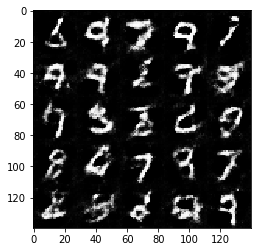

Epoch 1/2... Batch 210... Discriminator Loss: 1.6106... Generator Loss: 1.1007
Epoch 1/2... Batch 220... Discriminator Loss: 1.5065... Generator Loss: 0.8787
Epoch 1/2... Batch 230... Discriminator Loss: 1.4608... Generator Loss: 0.8539
Epoch 1/2... Batch 240... Discriminator Loss: 1.4284... Generator Loss: 0.8840
Epoch 1/2... Batch 250... Discriminator Loss: 1.4839... Generator Loss: 0.6144
Epoch 1/2... Batch 260... Discriminator Loss: 1.4768... Generator Loss: 0.5283
Epoch 1/2... Batch 270... Discriminator Loss: 1.4711... Generator Loss: 0.7640
Epoch 1/2... Batch 280... Discriminator Loss: 1.5955... Generator Loss: 1.0997
Epoch 1/2... Batch 290... Discriminator Loss: 1.4320... Generator Loss: 0.9092
Epoch 1/2... Batch 300... Discriminator Loss: 1.4698... Generator Loss: 0.8946


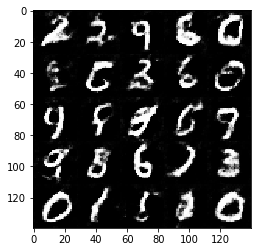

Epoch 1/2... Batch 310... Discriminator Loss: 1.5281... Generator Loss: 1.0821
Epoch 1/2... Batch 320... Discriminator Loss: 1.4135... Generator Loss: 0.8930
Epoch 1/2... Batch 330... Discriminator Loss: 1.4248... Generator Loss: 0.6661
Epoch 1/2... Batch 340... Discriminator Loss: 1.6114... Generator Loss: 1.2188
Epoch 1/2... Batch 350... Discriminator Loss: 1.3874... Generator Loss: 0.7643
Epoch 1/2... Batch 360... Discriminator Loss: 1.4127... Generator Loss: 0.7012
Epoch 1/2... Batch 370... Discriminator Loss: 1.7136... Generator Loss: 0.3343
Epoch 1/2... Batch 380... Discriminator Loss: 1.4455... Generator Loss: 0.5328
Epoch 1/2... Batch 390... Discriminator Loss: 1.6007... Generator Loss: 0.4151
Epoch 1/2... Batch 400... Discriminator Loss: 1.5707... Generator Loss: 0.4112


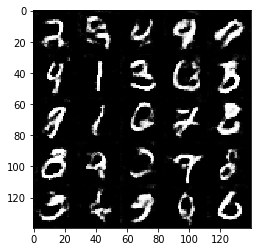

Epoch 1/2... Batch 410... Discriminator Loss: 1.6103... Generator Loss: 0.3935
Epoch 1/2... Batch 420... Discriminator Loss: 1.4883... Generator Loss: 0.5211
Epoch 1/2... Batch 430... Discriminator Loss: 1.7580... Generator Loss: 0.3133
Epoch 1/2... Batch 440... Discriminator Loss: 1.3721... Generator Loss: 0.7150
Epoch 1/2... Batch 450... Discriminator Loss: 1.4987... Generator Loss: 1.2590
Epoch 1/2... Batch 460... Discriminator Loss: 1.3943... Generator Loss: 0.6716
Epoch 2/2... Batch 470... Discriminator Loss: 1.4099... Generator Loss: 0.6655
Epoch 2/2... Batch 480... Discriminator Loss: 1.8079... Generator Loss: 0.2852
Epoch 2/2... Batch 490... Discriminator Loss: 1.3911... Generator Loss: 0.7176
Epoch 2/2... Batch 500... Discriminator Loss: 1.4843... Generator Loss: 0.5863


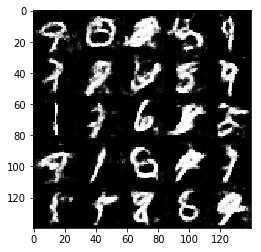

Epoch 2/2... Batch 510... Discriminator Loss: 1.4140... Generator Loss: 0.6054
Epoch 2/2... Batch 520... Discriminator Loss: 1.4082... Generator Loss: 0.8658
Epoch 2/2... Batch 530... Discriminator Loss: 1.4858... Generator Loss: 0.8495
Epoch 2/2... Batch 540... Discriminator Loss: 1.4243... Generator Loss: 0.6626
Epoch 2/2... Batch 550... Discriminator Loss: 1.4697... Generator Loss: 0.4892
Epoch 2/2... Batch 560... Discriminator Loss: 1.4139... Generator Loss: 0.5980
Epoch 2/2... Batch 570... Discriminator Loss: 1.3972... Generator Loss: 0.8215
Epoch 2/2... Batch 580... Discriminator Loss: 1.4604... Generator Loss: 0.9702
Epoch 2/2... Batch 590... Discriminator Loss: 1.3589... Generator Loss: 0.6946
Epoch 2/2... Batch 600... Discriminator Loss: 1.5822... Generator Loss: 0.3895


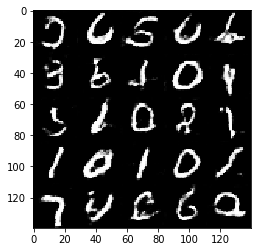

Epoch 2/2... Batch 610... Discriminator Loss: 1.4544... Generator Loss: 0.5283
Epoch 2/2... Batch 620... Discriminator Loss: 1.8158... Generator Loss: 1.5312
Epoch 2/2... Batch 630... Discriminator Loss: 1.3784... Generator Loss: 0.6393
Epoch 2/2... Batch 640... Discriminator Loss: 1.3861... Generator Loss: 0.8507
Epoch 2/2... Batch 650... Discriminator Loss: 1.3848... Generator Loss: 0.7015
Epoch 2/2... Batch 660... Discriminator Loss: 1.5319... Generator Loss: 0.4487
Epoch 2/2... Batch 670... Discriminator Loss: 1.4571... Generator Loss: 0.5000
Epoch 2/2... Batch 680... Discriminator Loss: 1.6565... Generator Loss: 1.4490
Epoch 2/2... Batch 690... Discriminator Loss: 1.4335... Generator Loss: 0.7125
Epoch 2/2... Batch 700... Discriminator Loss: 1.3624... Generator Loss: 0.7585


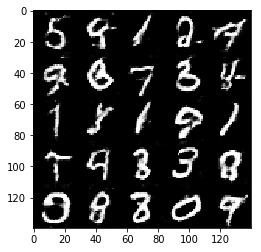

Epoch 2/2... Batch 710... Discriminator Loss: 1.4926... Generator Loss: 1.1559
Epoch 2/2... Batch 720... Discriminator Loss: 1.3580... Generator Loss: 0.7837
Epoch 2/2... Batch 730... Discriminator Loss: 1.6629... Generator Loss: 1.3862
Epoch 2/2... Batch 740... Discriminator Loss: 1.4008... Generator Loss: 0.6366
Epoch 2/2... Batch 750... Discriminator Loss: 1.7205... Generator Loss: 0.3520
Epoch 2/2... Batch 760... Discriminator Loss: 1.3975... Generator Loss: 0.5958
Epoch 2/2... Batch 770... Discriminator Loss: 1.6469... Generator Loss: 0.3818
Epoch 2/2... Batch 780... Discriminator Loss: 1.2620... Generator Loss: 0.9685
Epoch 2/2... Batch 790... Discriminator Loss: 1.3599... Generator Loss: 0.8786
Epoch 2/2... Batch 800... Discriminator Loss: 1.4418... Generator Loss: 0.8539


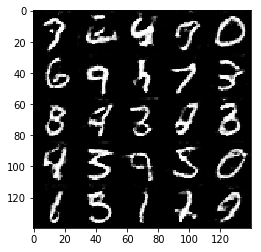

Epoch 2/2... Batch 810... Discriminator Loss: 1.4441... Generator Loss: 0.5983
Epoch 2/2... Batch 820... Discriminator Loss: 1.2633... Generator Loss: 0.7781
Epoch 2/2... Batch 830... Discriminator Loss: 1.8697... Generator Loss: 1.8074
Epoch 2/2... Batch 840... Discriminator Loss: 1.3764... Generator Loss: 0.6321
Epoch 2/2... Batch 850... Discriminator Loss: 1.6687... Generator Loss: 1.4748
Epoch 2/2... Batch 860... Discriminator Loss: 1.5014... Generator Loss: 0.4509
Epoch 2/2... Batch 870... Discriminator Loss: 1.3406... Generator Loss: 0.7330
Epoch 2/2... Batch 880... Discriminator Loss: 1.5120... Generator Loss: 0.4599
Epoch 2/2... Batch 890... Discriminator Loss: 1.5080... Generator Loss: 0.5129
Epoch 2/2... Batch 900... Discriminator Loss: 1.9614... Generator Loss: 0.2465


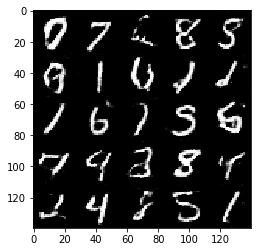

Epoch 2/2... Batch 910... Discriminator Loss: 1.3977... Generator Loss: 0.6883
Epoch 2/2... Batch 920... Discriminator Loss: 1.4054... Generator Loss: 0.5160
Epoch 2/2... Batch 930... Discriminator Loss: 1.5932... Generator Loss: 0.4079


In [15]:
batch_size = 128
z_dim = 100
learning_rate = .0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 2.9180... Generator Loss: 0.1159
Epoch 1/1... Batch 20... Discriminator Loss: 2.5967... Generator Loss: 0.1376
Epoch 1/1... Batch 30... Discriminator Loss: 2.7062... Generator Loss: 0.1748
Epoch 1/1... Batch 40... Discriminator Loss: 1.5202... Generator Loss: 0.9592
Epoch 1/1... Batch 50... Discriminator Loss: 1.7330... Generator Loss: 0.9110
Epoch 1/1... Batch 60... Discriminator Loss: 1.6246... Generator Loss: 0.6705
Epoch 1/1... Batch 70... Discriminator Loss: 1.6309... Generator Loss: 0.5151
Epoch 1/1... Batch 80... Discriminator Loss: 1.7990... Generator Loss: 0.4078
Epoch 1/1... Batch 90... Discriminator Loss: 1.9512... Generator Loss: 0.2915
Epoch 1/1... Batch 100... Discriminator Loss: 1.5728... Generator Loss: 0.4374


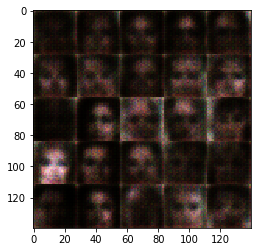

Epoch 1/1... Batch 110... Discriminator Loss: 1.8905... Generator Loss: 0.3360
Epoch 1/1... Batch 120... Discriminator Loss: 1.4700... Generator Loss: 1.0806
Epoch 1/1... Batch 130... Discriminator Loss: 1.6874... Generator Loss: 0.3782
Epoch 1/1... Batch 140... Discriminator Loss: 1.8935... Generator Loss: 0.3172
Epoch 1/1... Batch 150... Discriminator Loss: 1.9630... Generator Loss: 0.2709
Epoch 1/1... Batch 160... Discriminator Loss: 1.8783... Generator Loss: 0.3149
Epoch 1/1... Batch 170... Discriminator Loss: 1.5432... Generator Loss: 0.4785
Epoch 1/1... Batch 180... Discriminator Loss: 1.4867... Generator Loss: 0.6265
Epoch 1/1... Batch 190... Discriminator Loss: 1.6365... Generator Loss: 1.0927
Epoch 1/1... Batch 200... Discriminator Loss: 1.8037... Generator Loss: 0.3702


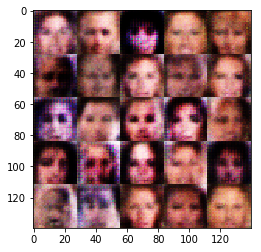

Epoch 1/1... Batch 210... Discriminator Loss: 1.5842... Generator Loss: 0.5489
Epoch 1/1... Batch 220... Discriminator Loss: 1.8044... Generator Loss: 0.3518
Epoch 1/1... Batch 230... Discriminator Loss: 1.5963... Generator Loss: 0.7244
Epoch 1/1... Batch 240... Discriminator Loss: 1.5752... Generator Loss: 0.9893
Epoch 1/1... Batch 250... Discriminator Loss: 1.6923... Generator Loss: 0.4654
Epoch 1/1... Batch 260... Discriminator Loss: 1.4128... Generator Loss: 0.7107
Epoch 1/1... Batch 270... Discriminator Loss: 1.5725... Generator Loss: 0.8824
Epoch 1/1... Batch 280... Discriminator Loss: 1.6762... Generator Loss: 0.5641
Epoch 1/1... Batch 290... Discriminator Loss: 1.4447... Generator Loss: 0.7328
Epoch 1/1... Batch 300... Discriminator Loss: 1.5770... Generator Loss: 0.5185


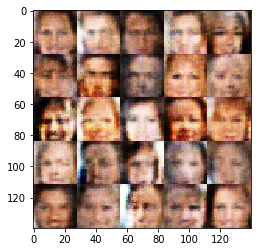

Epoch 1/1... Batch 310... Discriminator Loss: 1.4680... Generator Loss: 0.7230
Epoch 1/1... Batch 320... Discriminator Loss: 1.5491... Generator Loss: 0.6595
Epoch 1/1... Batch 330... Discriminator Loss: 1.5766... Generator Loss: 0.6138
Epoch 1/1... Batch 340... Discriminator Loss: 1.4959... Generator Loss: 0.6008
Epoch 1/1... Batch 350... Discriminator Loss: 1.6277... Generator Loss: 0.4771
Epoch 1/1... Batch 360... Discriminator Loss: 1.5841... Generator Loss: 0.5440
Epoch 1/1... Batch 370... Discriminator Loss: 1.5449... Generator Loss: 0.6908
Epoch 1/1... Batch 380... Discriminator Loss: 1.5275... Generator Loss: 0.5660
Epoch 1/1... Batch 390... Discriminator Loss: 1.4687... Generator Loss: 0.6123
Epoch 1/1... Batch 400... Discriminator Loss: 1.6299... Generator Loss: 0.5804


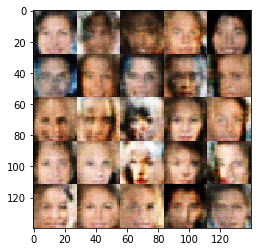

Epoch 1/1... Batch 410... Discriminator Loss: 1.5195... Generator Loss: 0.6202
Epoch 1/1... Batch 420... Discriminator Loss: 1.5874... Generator Loss: 0.5211
Epoch 1/1... Batch 430... Discriminator Loss: 1.2677... Generator Loss: 0.9052
Epoch 1/1... Batch 440... Discriminator Loss: 1.5652... Generator Loss: 0.5142
Epoch 1/1... Batch 450... Discriminator Loss: 1.5041... Generator Loss: 0.6483
Epoch 1/1... Batch 460... Discriminator Loss: 1.4784... Generator Loss: 0.7130
Epoch 1/1... Batch 470... Discriminator Loss: 1.4611... Generator Loss: 0.7940
Epoch 1/1... Batch 480... Discriminator Loss: 1.4876... Generator Loss: 0.6387
Epoch 1/1... Batch 490... Discriminator Loss: 1.4058... Generator Loss: 0.6274
Epoch 1/1... Batch 500... Discriminator Loss: 1.4726... Generator Loss: 0.6822


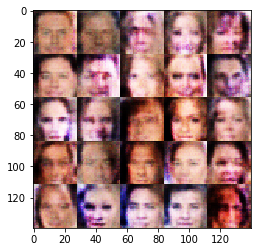

Epoch 1/1... Batch 510... Discriminator Loss: 1.4236... Generator Loss: 0.7912
Epoch 1/1... Batch 520... Discriminator Loss: 1.5759... Generator Loss: 0.4783
Epoch 1/1... Batch 530... Discriminator Loss: 1.3163... Generator Loss: 1.0150
Epoch 1/1... Batch 540... Discriminator Loss: 1.4359... Generator Loss: 0.6621
Epoch 1/1... Batch 550... Discriminator Loss: 1.3629... Generator Loss: 1.1192
Epoch 1/1... Batch 560... Discriminator Loss: 1.5896... Generator Loss: 0.4271
Epoch 1/1... Batch 570... Discriminator Loss: 1.4362... Generator Loss: 0.5835
Epoch 1/1... Batch 580... Discriminator Loss: 1.3296... Generator Loss: 0.8488
Epoch 1/1... Batch 590... Discriminator Loss: 1.3552... Generator Loss: 1.4046
Epoch 1/1... Batch 600... Discriminator Loss: 1.4277... Generator Loss: 0.7413


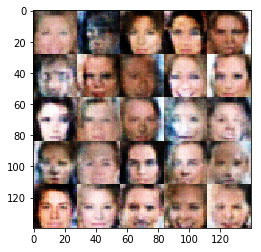

Epoch 1/1... Batch 610... Discriminator Loss: 1.4705... Generator Loss: 0.6357
Epoch 1/1... Batch 620... Discriminator Loss: 1.4839... Generator Loss: 0.5479
Epoch 1/1... Batch 630... Discriminator Loss: 1.5085... Generator Loss: 0.5581
Epoch 1/1... Batch 640... Discriminator Loss: 1.5793... Generator Loss: 0.4339
Epoch 1/1... Batch 650... Discriminator Loss: 1.7099... Generator Loss: 0.3841
Epoch 1/1... Batch 660... Discriminator Loss: 1.6758... Generator Loss: 0.3908
Epoch 1/1... Batch 670... Discriminator Loss: 1.6656... Generator Loss: 0.3957
Epoch 1/1... Batch 680... Discriminator Loss: 1.4090... Generator Loss: 0.5869
Epoch 1/1... Batch 690... Discriminator Loss: 1.5155... Generator Loss: 0.5636
Epoch 1/1... Batch 700... Discriminator Loss: 1.4259... Generator Loss: 0.6708


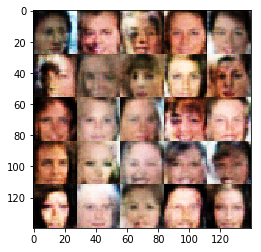

Epoch 1/1... Batch 710... Discriminator Loss: 1.3630... Generator Loss: 0.7289
Epoch 1/1... Batch 720... Discriminator Loss: 1.5038... Generator Loss: 0.5144
Epoch 1/1... Batch 730... Discriminator Loss: 1.3693... Generator Loss: 0.7253
Epoch 1/1... Batch 740... Discriminator Loss: 1.4867... Generator Loss: 0.5902
Epoch 1/1... Batch 750... Discriminator Loss: 1.5066... Generator Loss: 0.5943
Epoch 1/1... Batch 760... Discriminator Loss: 1.5077... Generator Loss: 0.5689
Epoch 1/1... Batch 770... Discriminator Loss: 1.4533... Generator Loss: 0.6103
Epoch 1/1... Batch 780... Discriminator Loss: 1.4346... Generator Loss: 0.6762
Epoch 1/1... Batch 790... Discriminator Loss: 1.5102... Generator Loss: 0.5208
Epoch 1/1... Batch 800... Discriminator Loss: 1.4764... Generator Loss: 0.5710


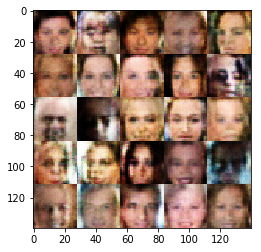

Epoch 1/1... Batch 810... Discriminator Loss: 1.3790... Generator Loss: 0.7090
Epoch 1/1... Batch 820... Discriminator Loss: 1.5333... Generator Loss: 0.6669
Epoch 1/1... Batch 830... Discriminator Loss: 1.8236... Generator Loss: 0.3041
Epoch 1/1... Batch 840... Discriminator Loss: 1.6382... Generator Loss: 0.5110
Epoch 1/1... Batch 850... Discriminator Loss: 1.4551... Generator Loss: 0.7000
Epoch 1/1... Batch 860... Discriminator Loss: 1.3510... Generator Loss: 0.9014
Epoch 1/1... Batch 870... Discriminator Loss: 1.5887... Generator Loss: 0.5076
Epoch 1/1... Batch 880... Discriminator Loss: 1.5187... Generator Loss: 0.6726
Epoch 1/1... Batch 890... Discriminator Loss: 1.4276... Generator Loss: 0.6597
Epoch 1/1... Batch 900... Discriminator Loss: 1.4767... Generator Loss: 0.5907


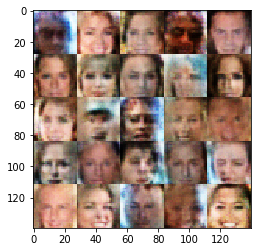

Epoch 1/1... Batch 910... Discriminator Loss: 1.3804... Generator Loss: 0.6617
Epoch 1/1... Batch 920... Discriminator Loss: 1.4676... Generator Loss: 0.4993
Epoch 1/1... Batch 930... Discriminator Loss: 1.2583... Generator Loss: 0.9814
Epoch 1/1... Batch 940... Discriminator Loss: 1.5521... Generator Loss: 0.4858
Epoch 1/1... Batch 950... Discriminator Loss: 1.3868... Generator Loss: 0.9407
Epoch 1/1... Batch 960... Discriminator Loss: 1.5617... Generator Loss: 0.5850
Epoch 1/1... Batch 970... Discriminator Loss: 1.3921... Generator Loss: 0.6612
Epoch 1/1... Batch 980... Discriminator Loss: 1.4910... Generator Loss: 0.5662
Epoch 1/1... Batch 990... Discriminator Loss: 1.4156... Generator Loss: 0.6892
Epoch 1/1... Batch 1000... Discriminator Loss: 1.5409... Generator Loss: 0.7597


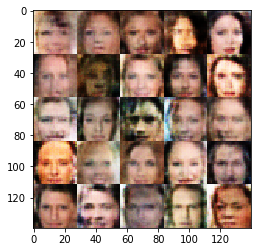

Epoch 1/1... Batch 1010... Discriminator Loss: 1.4246... Generator Loss: 0.6620
Epoch 1/1... Batch 1020... Discriminator Loss: 1.4851... Generator Loss: 0.5654
Epoch 1/1... Batch 1030... Discriminator Loss: 1.4184... Generator Loss: 0.7033
Epoch 1/1... Batch 1040... Discriminator Loss: 1.5694... Generator Loss: 0.5878
Epoch 1/1... Batch 1050... Discriminator Loss: 1.4957... Generator Loss: 0.6196
Epoch 1/1... Batch 1060... Discriminator Loss: 1.3220... Generator Loss: 0.9582
Epoch 1/1... Batch 1070... Discriminator Loss: 1.2865... Generator Loss: 0.8155
Epoch 1/1... Batch 1080... Discriminator Loss: 1.5896... Generator Loss: 0.4180
Epoch 1/1... Batch 1090... Discriminator Loss: 1.5302... Generator Loss: 0.5744
Epoch 1/1... Batch 1100... Discriminator Loss: 1.5646... Generator Loss: 0.4274


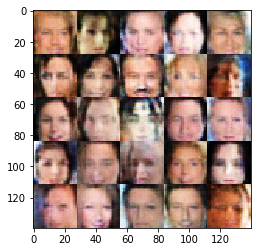

Epoch 1/1... Batch 1110... Discriminator Loss: 1.3913... Generator Loss: 0.6483
Epoch 1/1... Batch 1120... Discriminator Loss: 1.5218... Generator Loss: 0.6633
Epoch 1/1... Batch 1130... Discriminator Loss: 1.4389... Generator Loss: 0.7134
Epoch 1/1... Batch 1140... Discriminator Loss: 1.4907... Generator Loss: 0.5597
Epoch 1/1... Batch 1150... Discriminator Loss: 1.4846... Generator Loss: 0.7105
Epoch 1/1... Batch 1160... Discriminator Loss: 1.5583... Generator Loss: 0.8902
Epoch 1/1... Batch 1170... Discriminator Loss: 1.5482... Generator Loss: 0.6128
Epoch 1/1... Batch 1180... Discriminator Loss: 1.4488... Generator Loss: 0.6137
Epoch 1/1... Batch 1190... Discriminator Loss: 1.3515... Generator Loss: 0.9082
Epoch 1/1... Batch 1200... Discriminator Loss: 1.6353... Generator Loss: 0.6457


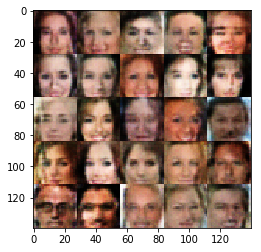

Epoch 1/1... Batch 1210... Discriminator Loss: 1.4786... Generator Loss: 0.5849
Epoch 1/1... Batch 1220... Discriminator Loss: 1.4815... Generator Loss: 0.9309
Epoch 1/1... Batch 1230... Discriminator Loss: 1.6337... Generator Loss: 0.4735
Epoch 1/1... Batch 1240... Discriminator Loss: 1.4123... Generator Loss: 0.6837
Epoch 1/1... Batch 1250... Discriminator Loss: 1.6088... Generator Loss: 0.4726
Epoch 1/1... Batch 1260... Discriminator Loss: 1.6136... Generator Loss: 0.4948
Epoch 1/1... Batch 1270... Discriminator Loss: 1.3080... Generator Loss: 0.8418
Epoch 1/1... Batch 1280... Discriminator Loss: 1.5135... Generator Loss: 0.4703
Epoch 1/1... Batch 1290... Discriminator Loss: 1.4588... Generator Loss: 0.4924
Epoch 1/1... Batch 1300... Discriminator Loss: 1.5396... Generator Loss: 0.6247


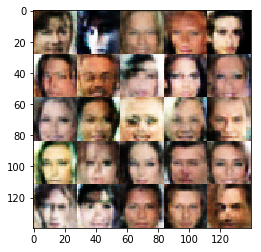

Epoch 1/1... Batch 1310... Discriminator Loss: 1.5536... Generator Loss: 0.7623
Epoch 1/1... Batch 1320... Discriminator Loss: 1.6371... Generator Loss: 0.4082
Epoch 1/1... Batch 1330... Discriminator Loss: 1.4429... Generator Loss: 0.6813
Epoch 1/1... Batch 1340... Discriminator Loss: 1.7563... Generator Loss: 0.3567
Epoch 1/1... Batch 1350... Discriminator Loss: 1.4920... Generator Loss: 0.5299
Epoch 1/1... Batch 1360... Discriminator Loss: 1.1756... Generator Loss: 1.2753
Epoch 1/1... Batch 1370... Discriminator Loss: 1.8179... Generator Loss: 0.3269
Epoch 1/1... Batch 1380... Discriminator Loss: 1.5720... Generator Loss: 0.4143
Epoch 1/1... Batch 1390... Discriminator Loss: 1.3469... Generator Loss: 0.6923
Epoch 1/1... Batch 1400... Discriminator Loss: 1.5263... Generator Loss: 0.6515


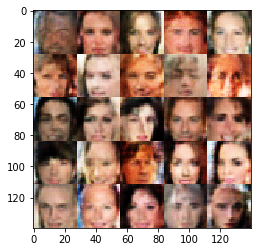

Epoch 1/1... Batch 1410... Discriminator Loss: 1.5714... Generator Loss: 0.5016
Epoch 1/1... Batch 1420... Discriminator Loss: 1.5363... Generator Loss: 0.6541
Epoch 1/1... Batch 1430... Discriminator Loss: 1.3395... Generator Loss: 0.8712
Epoch 1/1... Batch 1440... Discriminator Loss: 1.3056... Generator Loss: 0.8769
Epoch 1/1... Batch 1450... Discriminator Loss: 1.6970... Generator Loss: 0.4074
Epoch 1/1... Batch 1460... Discriminator Loss: 1.6512... Generator Loss: 0.3990
Epoch 1/1... Batch 1470... Discriminator Loss: 1.3737... Generator Loss: 0.7914
Epoch 1/1... Batch 1480... Discriminator Loss: 1.1812... Generator Loss: 1.1049
Epoch 1/1... Batch 1490... Discriminator Loss: 1.6905... Generator Loss: 0.4176
Epoch 1/1... Batch 1500... Discriminator Loss: 1.4126... Generator Loss: 0.8501


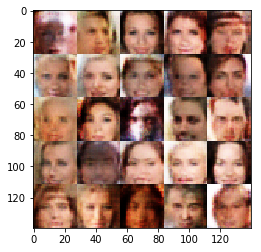

Epoch 1/1... Batch 1510... Discriminator Loss: 1.5466... Generator Loss: 0.4761
Epoch 1/1... Batch 1520... Discriminator Loss: 1.2467... Generator Loss: 1.2266
Epoch 1/1... Batch 1530... Discriminator Loss: 1.1444... Generator Loss: 1.0017
Epoch 1/1... Batch 1540... Discriminator Loss: 1.2001... Generator Loss: 1.0281
Epoch 1/1... Batch 1550... Discriminator Loss: 1.5813... Generator Loss: 0.4269
Epoch 1/1... Batch 1560... Discriminator Loss: 1.4757... Generator Loss: 0.4947
Epoch 1/1... Batch 1570... Discriminator Loss: 1.5453... Generator Loss: 0.6291
Epoch 1/1... Batch 1580... Discriminator Loss: 1.3982... Generator Loss: 0.7987
Epoch 1/1... Batch 1590... Discriminator Loss: 1.8008... Generator Loss: 0.3013
Epoch 1/1... Batch 1600... Discriminator Loss: 1.2722... Generator Loss: 1.0523


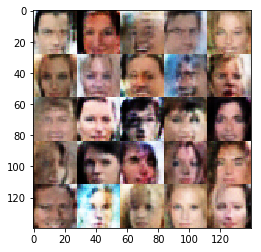

Epoch 1/1... Batch 1610... Discriminator Loss: 1.4538... Generator Loss: 0.5787
Epoch 1/1... Batch 1620... Discriminator Loss: 1.3894... Generator Loss: 0.9319
Epoch 1/1... Batch 1630... Discriminator Loss: 1.4587... Generator Loss: 0.5262
Epoch 1/1... Batch 1640... Discriminator Loss: 1.3091... Generator Loss: 0.9199
Epoch 1/1... Batch 1650... Discriminator Loss: 1.6460... Generator Loss: 0.4548
Epoch 1/1... Batch 1660... Discriminator Loss: 1.4514... Generator Loss: 0.6860
Epoch 1/1... Batch 1670... Discriminator Loss: 1.0532... Generator Loss: 1.1814
Epoch 1/1... Batch 1680... Discriminator Loss: 1.5261... Generator Loss: 0.6277
Epoch 1/1... Batch 1690... Discriminator Loss: 1.6928... Generator Loss: 0.4792
Epoch 1/1... Batch 1700... Discriminator Loss: 1.6606... Generator Loss: 0.3998


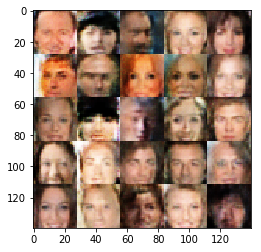

Epoch 1/1... Batch 1710... Discriminator Loss: 1.5233... Generator Loss: 0.6015
Epoch 1/1... Batch 1720... Discriminator Loss: 1.3942... Generator Loss: 0.6718
Epoch 1/1... Batch 1730... Discriminator Loss: 1.4536... Generator Loss: 0.5668
Epoch 1/1... Batch 1740... Discriminator Loss: 1.1785... Generator Loss: 1.1356
Epoch 1/1... Batch 1750... Discriminator Loss: 1.7912... Generator Loss: 0.4769
Epoch 1/1... Batch 1760... Discriminator Loss: 1.3564... Generator Loss: 0.6697
Epoch 1/1... Batch 1770... Discriminator Loss: 1.5680... Generator Loss: 0.4676
Epoch 1/1... Batch 1780... Discriminator Loss: 1.5276... Generator Loss: 0.5005
Epoch 1/1... Batch 1790... Discriminator Loss: 1.7220... Generator Loss: 0.4013
Epoch 1/1... Batch 1800... Discriminator Loss: 1.4467... Generator Loss: 0.8801


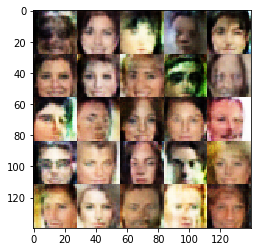

Epoch 1/1... Batch 1810... Discriminator Loss: 1.6701... Generator Loss: 0.4394
Epoch 1/1... Batch 1820... Discriminator Loss: 1.5510... Generator Loss: 0.5450
Epoch 1/1... Batch 1830... Discriminator Loss: 1.5242... Generator Loss: 0.6563
Epoch 1/1... Batch 1840... Discriminator Loss: 1.4878... Generator Loss: 0.6343
Epoch 1/1... Batch 1850... Discriminator Loss: 1.4304... Generator Loss: 0.6651
Epoch 1/1... Batch 1860... Discriminator Loss: 1.6126... Generator Loss: 0.5654
Epoch 1/1... Batch 1870... Discriminator Loss: 1.6119... Generator Loss: 0.4945
Epoch 1/1... Batch 1880... Discriminator Loss: 1.4501... Generator Loss: 0.6513
Epoch 1/1... Batch 1890... Discriminator Loss: 1.5355... Generator Loss: 0.5166
Epoch 1/1... Batch 1900... Discriminator Loss: 1.5119... Generator Loss: 0.4926


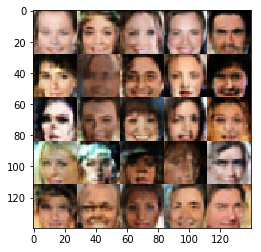

Epoch 1/1... Batch 1910... Discriminator Loss: 1.6232... Generator Loss: 0.4220
Epoch 1/1... Batch 1920... Discriminator Loss: 1.5715... Generator Loss: 0.6030
Epoch 1/1... Batch 1930... Discriminator Loss: 1.4558... Generator Loss: 0.7637
Epoch 1/1... Batch 1940... Discriminator Loss: 1.6968... Generator Loss: 0.4686
Epoch 1/1... Batch 1950... Discriminator Loss: 1.5578... Generator Loss: 0.4799
Epoch 1/1... Batch 1960... Discriminator Loss: 1.4599... Generator Loss: 0.7352
Epoch 1/1... Batch 1970... Discriminator Loss: 1.4722... Generator Loss: 0.6297
Epoch 1/1... Batch 1980... Discriminator Loss: 1.7418... Generator Loss: 0.3674
Epoch 1/1... Batch 1990... Discriminator Loss: 1.6379... Generator Loss: 0.4687
Epoch 1/1... Batch 2000... Discriminator Loss: 1.5270... Generator Loss: 0.6798


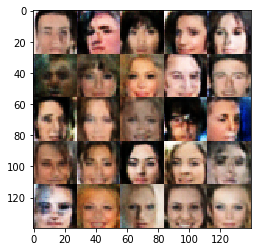

Epoch 1/1... Batch 2010... Discriminator Loss: 1.5220... Generator Loss: 0.6215
Epoch 1/1... Batch 2020... Discriminator Loss: 1.5570... Generator Loss: 0.4724
Epoch 1/1... Batch 2030... Discriminator Loss: 1.6085... Generator Loss: 0.5962
Epoch 1/1... Batch 2040... Discriminator Loss: 1.5453... Generator Loss: 0.6173
Epoch 1/1... Batch 2050... Discriminator Loss: 1.7960... Generator Loss: 0.3660
Epoch 1/1... Batch 2060... Discriminator Loss: 1.3822... Generator Loss: 0.7392
Epoch 1/1... Batch 2070... Discriminator Loss: 1.7092... Generator Loss: 0.4417
Epoch 1/1... Batch 2080... Discriminator Loss: 1.4213... Generator Loss: 0.7452
Epoch 1/1... Batch 2090... Discriminator Loss: 1.5122... Generator Loss: 0.6394
Epoch 1/1... Batch 2100... Discriminator Loss: 1.5861... Generator Loss: 0.4167


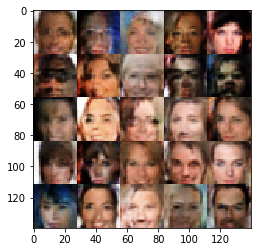

Epoch 1/1... Batch 2110... Discriminator Loss: 1.4796... Generator Loss: 0.6357
Epoch 1/1... Batch 2120... Discriminator Loss: 1.6414... Generator Loss: 0.4147
Epoch 1/1... Batch 2130... Discriminator Loss: 1.6985... Generator Loss: 0.3769
Epoch 1/1... Batch 2140... Discriminator Loss: 1.5998... Generator Loss: 0.6363
Epoch 1/1... Batch 2150... Discriminator Loss: 1.5366... Generator Loss: 0.5109
Epoch 1/1... Batch 2160... Discriminator Loss: 1.6941... Generator Loss: 0.3899
Epoch 1/1... Batch 2170... Discriminator Loss: 1.5890... Generator Loss: 0.5077
Epoch 1/1... Batch 2180... Discriminator Loss: 1.7235... Generator Loss: 0.3900
Epoch 1/1... Batch 2190... Discriminator Loss: 1.5651... Generator Loss: 0.5193
Epoch 1/1... Batch 2200... Discriminator Loss: 1.2955... Generator Loss: 1.0223


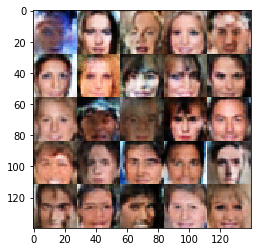

Epoch 1/1... Batch 2210... Discriminator Loss: 1.6963... Generator Loss: 0.3747
Epoch 1/1... Batch 2220... Discriminator Loss: 1.5277... Generator Loss: 0.5545
Epoch 1/1... Batch 2230... Discriminator Loss: 1.5678... Generator Loss: 0.5220
Epoch 1/1... Batch 2240... Discriminator Loss: 1.4411... Generator Loss: 0.6663
Epoch 1/1... Batch 2250... Discriminator Loss: 1.6320... Generator Loss: 0.4165
Epoch 1/1... Batch 2260... Discriminator Loss: 1.6278... Generator Loss: 0.4243
Epoch 1/1... Batch 2270... Discriminator Loss: 1.4928... Generator Loss: 0.5448
Epoch 1/1... Batch 2280... Discriminator Loss: 1.5540... Generator Loss: 0.5240
Epoch 1/1... Batch 2290... Discriminator Loss: 1.6346... Generator Loss: 0.5219
Epoch 1/1... Batch 2300... Discriminator Loss: 1.5532... Generator Loss: 0.5379


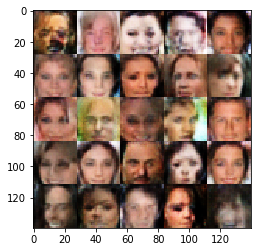

Epoch 1/1... Batch 2310... Discriminator Loss: 1.5956... Generator Loss: 0.5667
Epoch 1/1... Batch 2320... Discriminator Loss: 1.5518... Generator Loss: 0.5178
Epoch 1/1... Batch 2330... Discriminator Loss: 1.5452... Generator Loss: 0.4945
Epoch 1/1... Batch 2340... Discriminator Loss: 1.5814... Generator Loss: 0.4416
Epoch 1/1... Batch 2350... Discriminator Loss: 1.6417... Generator Loss: 0.5016
Epoch 1/1... Batch 2360... Discriminator Loss: 1.5676... Generator Loss: 0.4377
Epoch 1/1... Batch 2370... Discriminator Loss: 1.5522... Generator Loss: 0.5093
Epoch 1/1... Batch 2380... Discriminator Loss: 1.7078... Generator Loss: 0.5667
Epoch 1/1... Batch 2390... Discriminator Loss: 1.6598... Generator Loss: 0.4227
Epoch 1/1... Batch 2400... Discriminator Loss: 1.4858... Generator Loss: 0.6201


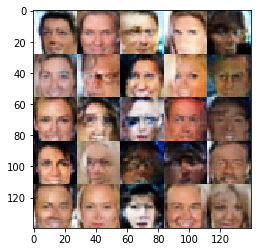

Epoch 1/1... Batch 2410... Discriminator Loss: 1.5581... Generator Loss: 0.6115
Epoch 1/1... Batch 2420... Discriminator Loss: 1.4124... Generator Loss: 0.6229
Epoch 1/1... Batch 2430... Discriminator Loss: 1.4718... Generator Loss: 0.7262
Epoch 1/1... Batch 2440... Discriminator Loss: 1.5190... Generator Loss: 0.5491
Epoch 1/1... Batch 2450... Discriminator Loss: 1.6231... Generator Loss: 0.4443
Epoch 1/1... Batch 2460... Discriminator Loss: 1.8359... Generator Loss: 0.3363
Epoch 1/1... Batch 2470... Discriminator Loss: 1.5528... Generator Loss: 0.4780
Epoch 1/1... Batch 2480... Discriminator Loss: 1.6191... Generator Loss: 0.5451
Epoch 1/1... Batch 2490... Discriminator Loss: 1.3918... Generator Loss: 0.6190
Epoch 1/1... Batch 2500... Discriminator Loss: 1.5045... Generator Loss: 0.5471


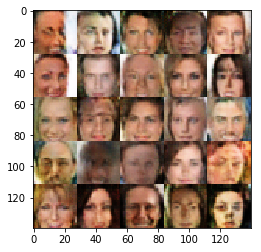

Epoch 1/1... Batch 2510... Discriminator Loss: 1.4053... Generator Loss: 0.8499
Epoch 1/1... Batch 2520... Discriminator Loss: 1.6128... Generator Loss: 0.6182
Epoch 1/1... Batch 2530... Discriminator Loss: 1.5883... Generator Loss: 0.4660
Epoch 1/1... Batch 2540... Discriminator Loss: 1.4954... Generator Loss: 0.5183
Epoch 1/1... Batch 2550... Discriminator Loss: 1.5472... Generator Loss: 0.5235
Epoch 1/1... Batch 2560... Discriminator Loss: 1.6364... Generator Loss: 0.4133
Epoch 1/1... Batch 2570... Discriminator Loss: 1.6148... Generator Loss: 0.4796
Epoch 1/1... Batch 2580... Discriminator Loss: 1.4843... Generator Loss: 0.6663
Epoch 1/1... Batch 2590... Discriminator Loss: 1.6780... Generator Loss: 0.3935
Epoch 1/1... Batch 2600... Discriminator Loss: 1.2952... Generator Loss: 0.8534


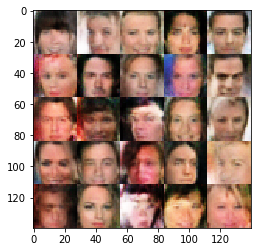

Epoch 1/1... Batch 2610... Discriminator Loss: 1.6002... Generator Loss: 0.4517
Epoch 1/1... Batch 2620... Discriminator Loss: 1.5262... Generator Loss: 0.4774
Epoch 1/1... Batch 2630... Discriminator Loss: 1.2849... Generator Loss: 0.8330
Epoch 1/1... Batch 2640... Discriminator Loss: 1.6600... Generator Loss: 1.3016
Epoch 1/1... Batch 2650... Discriminator Loss: 1.6186... Generator Loss: 0.5026
Epoch 1/1... Batch 2660... Discriminator Loss: 1.6546... Generator Loss: 0.4305
Epoch 1/1... Batch 2670... Discriminator Loss: 1.7317... Generator Loss: 0.3690
Epoch 1/1... Batch 2680... Discriminator Loss: 1.6302... Generator Loss: 0.4161
Epoch 1/1... Batch 2690... Discriminator Loss: 1.6377... Generator Loss: 0.4935
Epoch 1/1... Batch 2700... Discriminator Loss: 1.4483... Generator Loss: 0.7067


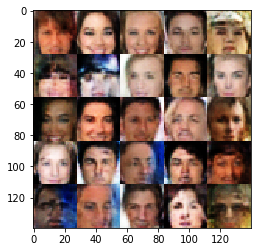

Epoch 1/1... Batch 2710... Discriminator Loss: 1.5382... Generator Loss: 0.6601
Epoch 1/1... Batch 2720... Discriminator Loss: 1.6392... Generator Loss: 0.4321
Epoch 1/1... Batch 2730... Discriminator Loss: 1.7313... Generator Loss: 0.3807
Epoch 1/1... Batch 2740... Discriminator Loss: 1.6398... Generator Loss: 0.4971
Epoch 1/1... Batch 2750... Discriminator Loss: 1.7207... Generator Loss: 0.5784
Epoch 1/1... Batch 2760... Discriminator Loss: 1.5923... Generator Loss: 0.5876
Epoch 1/1... Batch 2770... Discriminator Loss: 1.7278... Generator Loss: 0.3969
Epoch 1/1... Batch 2780... Discriminator Loss: 1.5960... Generator Loss: 0.4881
Epoch 1/1... Batch 2790... Discriminator Loss: 1.7220... Generator Loss: 0.3780
Epoch 1/1... Batch 2800... Discriminator Loss: 1.7226... Generator Loss: 0.3777


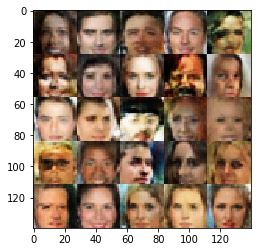

Epoch 1/1... Batch 2810... Discriminator Loss: 1.7833... Generator Loss: 0.3773
Epoch 1/1... Batch 2820... Discriminator Loss: 1.4915... Generator Loss: 0.5353
Epoch 1/1... Batch 2830... Discriminator Loss: 1.5951... Generator Loss: 0.4823
Epoch 1/1... Batch 2840... Discriminator Loss: 1.5464... Generator Loss: 0.6160
Epoch 1/1... Batch 2850... Discriminator Loss: 1.6056... Generator Loss: 0.5160
Epoch 1/1... Batch 2860... Discriminator Loss: 1.5284... Generator Loss: 0.6224
Epoch 1/1... Batch 2870... Discriminator Loss: 1.5570... Generator Loss: 0.5399
Epoch 1/1... Batch 2880... Discriminator Loss: 1.6783... Generator Loss: 0.4468
Epoch 1/1... Batch 2890... Discriminator Loss: 1.4773... Generator Loss: 0.5484
Epoch 1/1... Batch 2900... Discriminator Loss: 1.7906... Generator Loss: 0.3674


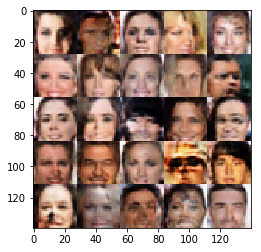

Epoch 1/1... Batch 2910... Discriminator Loss: 1.5822... Generator Loss: 0.5412
Epoch 1/1... Batch 2920... Discriminator Loss: 1.6435... Generator Loss: 0.5626
Epoch 1/1... Batch 2930... Discriminator Loss: 1.5072... Generator Loss: 0.5870
Epoch 1/1... Batch 2940... Discriminator Loss: 1.6072... Generator Loss: 0.4679
Epoch 1/1... Batch 2950... Discriminator Loss: 1.7312... Generator Loss: 0.3502
Epoch 1/1... Batch 2960... Discriminator Loss: 1.5760... Generator Loss: 0.4953
Epoch 1/1... Batch 2970... Discriminator Loss: 1.6125... Generator Loss: 0.4737
Epoch 1/1... Batch 2980... Discriminator Loss: 1.7534... Generator Loss: 0.3382
Epoch 1/1... Batch 2990... Discriminator Loss: 1.6331... Generator Loss: 0.4300
Epoch 1/1... Batch 3000... Discriminator Loss: 1.7307... Generator Loss: 0.3985


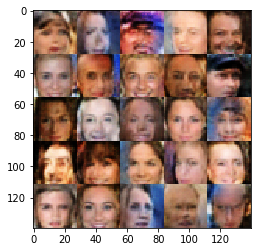

Epoch 1/1... Batch 3010... Discriminator Loss: 1.5795... Generator Loss: 0.4833
Epoch 1/1... Batch 3020... Discriminator Loss: 1.6263... Generator Loss: 0.5182
Epoch 1/1... Batch 3030... Discriminator Loss: 1.5330... Generator Loss: 0.5955
Epoch 1/1... Batch 3040... Discriminator Loss: 1.6773... Generator Loss: 0.5281
Epoch 1/1... Batch 3050... Discriminator Loss: 1.6480... Generator Loss: 0.4316
Epoch 1/1... Batch 3060... Discriminator Loss: 1.3679... Generator Loss: 0.6452
Epoch 1/1... Batch 3070... Discriminator Loss: 1.5968... Generator Loss: 0.4488
Epoch 1/1... Batch 3080... Discriminator Loss: 1.4703... Generator Loss: 0.6129
Epoch 1/1... Batch 3090... Discriminator Loss: 1.6564... Generator Loss: 0.4759
Epoch 1/1... Batch 3100... Discriminator Loss: 1.6193... Generator Loss: 0.4197


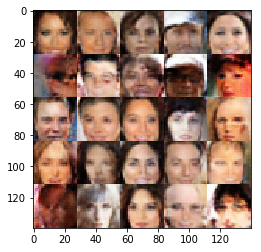

Epoch 1/1... Batch 3110... Discriminator Loss: 1.7089... Generator Loss: 0.5272
Epoch 1/1... Batch 3120... Discriminator Loss: 1.4803... Generator Loss: 0.5458
Epoch 1/1... Batch 3130... Discriminator Loss: 1.7798... Generator Loss: 0.3290
Epoch 1/1... Batch 3140... Discriminator Loss: 1.7105... Generator Loss: 0.5247
Epoch 1/1... Batch 3150... Discriminator Loss: 1.7257... Generator Loss: 0.3471
Epoch 1/1... Batch 3160... Discriminator Loss: 1.5542... Generator Loss: 0.5860


In [16]:
batch_size = 64
z_dim = 100
learning_rate = .0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.